# Learning Jammers: Loss Simulations
In this notebook, we will simulate different losses, compare their performance (BER) and have a look at their learned weights.

In [1]:
import os
# import drjit
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sionna
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')
# tf.config.run_functions_eagerly(True)

from jammer.simulation_model import *
from tensorflow.python.keras.losses import MeanAbsoluteError, MeanSquaredError, BinaryCrossentropy

In [2]:
# common parameters
model_parameters["perfect_csi"] = False
model_parameters["num_ut"] = 1
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = 1.0
model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = 1
jammer_parameters["trainable"] = True
model_parameters["return_symbols"] = True

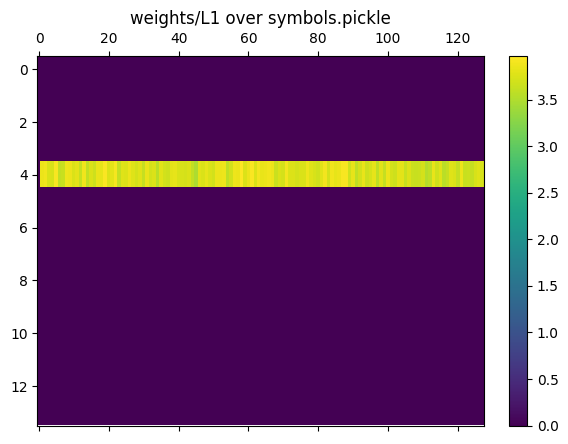

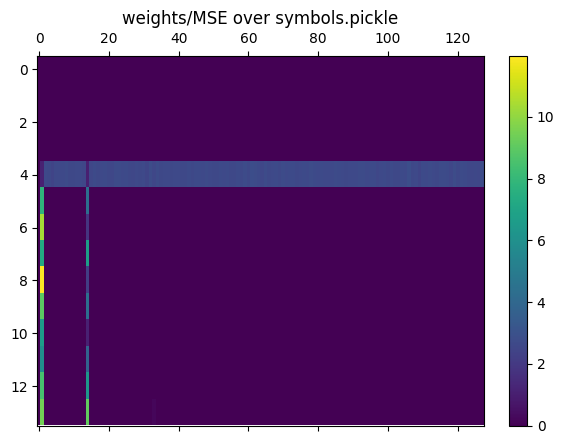

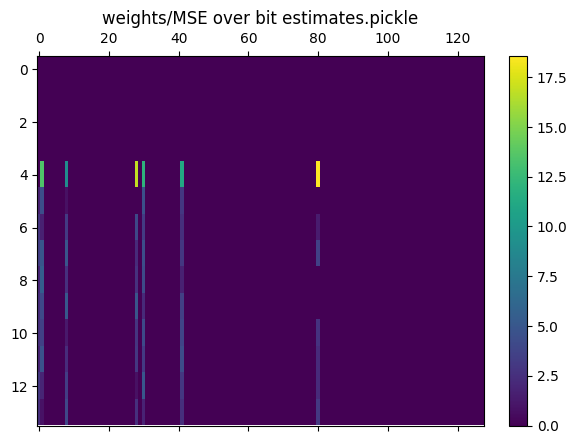

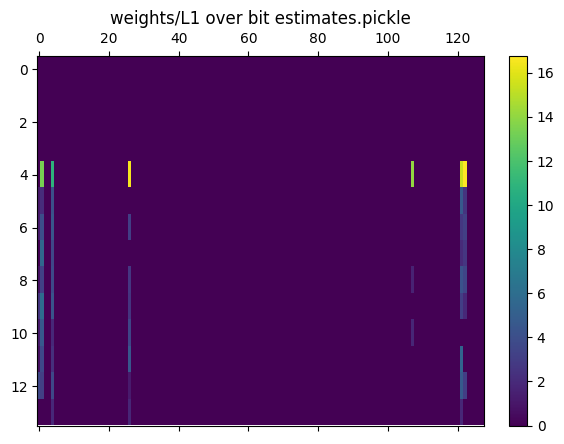

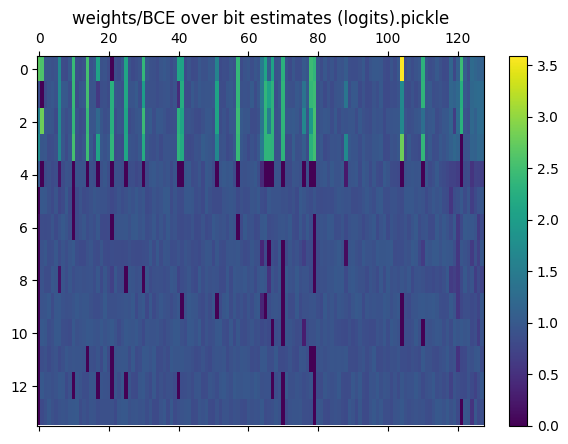

In [3]:
# needed, as keras MSE does not take |.|
abs_mse = lambda y_true, y_pred: tf.reduce_mean(tf.square(tf.abs(y_true - y_pred)))
# name, loss_fn, over symbols?, loss_over_logits
parameters = [
    ("L1 over symbols", negative_function(MeanAbsoluteError()), True, False),
    ("MSE over symbols", negative_function(abs_mse), True, False),
    ("MSE over bit estimates", negative_function(MeanSquaredError()), False, False),
    ("L1 over bit estimates", negative_function(MeanAbsoluteError()), False, False),
    ("BCE over bit estimates (logits)", BinaryCrossentropy(from_logits=True), False, True),
]

for name, loss_fn, over_symbols, loss_over_logits in parameters:
    model_parameters["return_symbols"] = over_symbols
    model = Model(**model_parameters)
    train_model(model,
                loss_fn=loss_fn,
                loss_over_logits=loss_over_logits,
                weights_filename=f"weights/{name}.pickle",
                log_tensorboard=True,
                log_weight_images=True,
                show_final_weights=True)

In [4]:
jammer_parameters["trainable"] = False
for name, loss_fn, over_symbols, loss_over_logits in parameters:
    filename = f"weights/{name}.pickle"
    model = Model(**model_parameters)
    load_weights(model, filename)
    simulate_model(model, name)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.4144e-01 | 1.0000e+00 |       33377 |      138240 |           60 |          60 |        15.8 |reached max iter       
   -3.571 | 2.2148e-01 | 1.0000e+00 |       30617 |      138240 |           60 |          60 |         1.5 |reached max iter       
   -2.143 | 1.8560e-01 | 1.0000e+00 |       25658 |      138240 |           60 |          60 |         1.5 |reached max iter       
   -0.714 | 1.7218e-01 | 1.0000e+00 |       23802 |      138240 |           60 |          60 |         1.5 |reached max iter       
    0.714 | 1.6748e-01 | 1.0000e+00 |       23152 |      138240 |           60 |          60 |         1.5 |reached max iter       
    2.143 | 1.6139e-01 | 1.0000e+00 |       22310 |      138240 |           60 |     

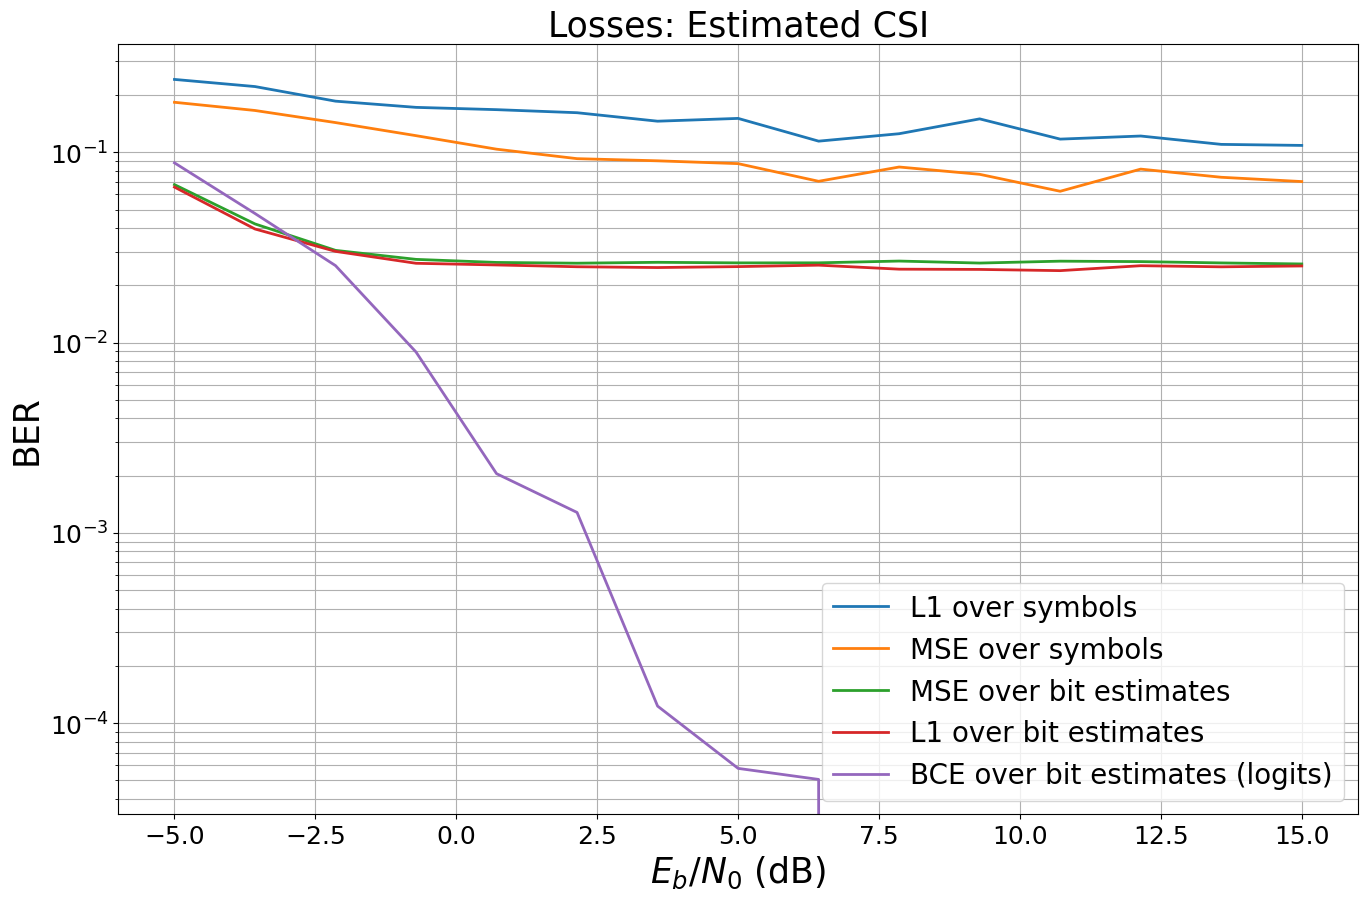

In [5]:
ber_plots.title = "Losses: Estimated CSI"
ber_plots()